In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import clean_functions as cl
import geopy
import utm
%pylab inline
pd.set_option('display.max_column',None)

Populating the interactive namespace from numpy and matplotlib


## Data gathering
Data gathering:
- Activities files (from 2015 - 2019, Ayuntamiento Madrid)
- Madrid population database (1st january 2019, Ayuntamiento Madrid)
- Madrid floating population (16-22 april 2018, Private source)

In [2]:
os.getcwd()

'/home/dsc/Python_notebooks/TFM/TBV/TBV_v1'

### Activities file: 
Data from madrid.es open data portal: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=23160329ff639410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default   
We load the file into memory as a pandas dataframe. Files are uncompressed.   
Careful with separators: some cleaning through Command Line has beeen necessary to remove "ambigous separators": clean versions of the files.   
Encoding is Latin9 (although in documentation UTF8 is mentioned).      
After checking all files available in Madrid web portal (locals, licences and activities (== epigrafes in Spanish), I will work over epigrafes file that contains all the locals and status.   
Since the study is being done on a yearly basis and 2019 data is only available till Sep'19, I will use the September versions for all the files   
I decided not use 2014 file since doesn'thave the same fields as the others and goes further in time.  

In [3]:
# 2019 data. A clean version is needed to correct wrong separators via command line
df_epi19 = pd.read_csv('Data/censolocales/OPEN DATA Locales-Epigrafes201909_clean.csv',sep=';',encoding='latin9')
# 2018 data. A clean version is needed to correct wrong separators via command line
df_epi18 = pd.read_csv('Data/censolocales/OPEN DATA Locales-Epigrafes201809_clean.csv',sep=';',encoding='latin9')
# 2017 data. September file was corrupted (many NaN). I will use Nov. file instead
df_epi17 = pd.read_csv('Data/censolocales/OPEN DATA Locales-Epigrafes201711_clean.csv',sep=';',encoding='latin9')
# 2016 data. This file is ok, no clean version is needed.
df_epi16 = pd.read_csv('Data/censolocales/OPEN DATA Locales-Epigrafes201609.csv',sep=';',encoding='latin9')
# 2015 data. This file is ok, no clean version is needed.
df_epi15 = pd.read_csv('Data/censolocales/OPEN DATA Locales-Epigrafes201509.csv',sep=';',encoding='latin9')

/home/dsc/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Each new year file contains the locals of previous years and the new that year. All of the have the same columns

In [5]:
df_epi19.shape, df_epi18.shape, df_epi17.shape, df_epi16.shape, df_epi15.shape

((163355, 46), (162467, 46), (161097, 46), (159604, 46), (157206, 46))

In [6]:
df_epi19.columns

Index(['id_local', 'id_distrito_local', 'desc_distrito_local',
       'id_barrio_local', 'desc_barrio_local', 'cod_barrio_local',
       'id_seccion_censal_local', 'desc_seccion_censal_local',
       'coordenada_x_local', 'coordenada_y_local', 'id_tipo_acceso_local',
       'desc_tipo_acceso_local', 'id_situacion_local', 'desc_situacion_local',
       'id_vial_edificio', 'clase_vial_edificio', 'desc_vial_edificio',
       'id_ndp_edificio', 'id_clase_ndp_edificio', 'nom_edificio',
       'num_edificio', 'cal_edificio', 'secuencial_local_PC', 'id_vial_acceso',
       'clase_vial_acceso', 'desc_vial_acceso', 'id_ndp_acceso',
       'id_clase_ndp_acceso', 'nom_acceso', 'num_acceso', 'cal_acceso',
       'coordenada_x_agrupacion', 'coordenada_y_agrup', 'id_agrupacion',
       'nombre_agrupacion', 'id_tipo_agrup', 'desc_tipo_agrup',
       'id_planta_agrupado', 'id_local_agrupado', 'rotulo', 'id_seccion',
       'desc_seccion', 'id_division', 'desc_division', 'id_epigrafe',
       'desc_epi

In [7]:
df_epi19.head(2)

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,rotulo,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe
0,270440895,3,RETIRO,304,IBIZA,NaN,NaN,55,0,0,NaN,Agrupado,NaN,Abierto,370400,CALLE,IBIZA ...,11012388,1,NUM,8,,0,NaN,CALLE,IBIZA ...,11012388,1,NUM,8,,"442533,58","4474389,51",99000191.0,MERCADO MUNICIPAL DE IBIZA,12.0,Mercado Municipal,PB,7,BAR HERMANOS BENAYAS,I,HOSTELERIA,56,SERVICIOS DE COMIDAS Y BEBIDAS,563005,BAR SIN COCINA
1,270440899,5,CHAMARTIN,502,PROSPERIDAD,NaN,NaN,23,"443460,59","4477604,5",NaN,Puerta Calle,NaN,Abierto,210200,CALLE,CORAZON DE MARIA ...,20138306,1,NUM,57,,20,NaN,CALLE,CORAZON DE MARIA ...,20138306,1,NUM,57,,NaN,NaN,NaN,NaN,NaN,NaN,PB,NaN,LA PARRILLA BERENGUER,I,HOSTELERIA,56,SERVICIOS DE COMIDAS Y BEBIDAS,561005,BAR CON COCINA


There are more rows in the files than unique locals. This is because the same local can be licenced with one or more activities

In [8]:
len(df_epi19['id_local'].unique()), len(df_epi18['id_local'].unique()), len(df_epi17['id_local'].unique()),\
len(df_epi16['id_local'].unique()),len(df_epi15['id_local'].unique())

(147344, 146607, 145752, 144920, 144048)

### Madrid Population database
Data from madrid.es open data portal: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=1d755cde99be2410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

In [9]:
#Madrid population main KPIs
df1 = pd.read_excel('Data/censopob/censo_Madrid_distrito.xlsx')
df1.head()
df1.dtypes

id_distrito_local                                                           int64
distrito                                                                   object
Población                                                                   int64
Hombre                                                                      int64
Mujeres                                                                     int64
Densidad (Habitantes / Ha.)                                               float64
Edad promedio                                                             float64
Total Hogares                                                               int64
Españoles                                                                   int64
Extranjeros                                                                 int64
Mixtos                                                                      int64
Una mujer sola de 16 a 64 años                                              int64
Un hombre solo d

### Madrid floating population
Info from Kineo. Floating population in Madrid Districts from 14-22 of april 2018

In [10]:
# Floating_population
df2 = pd.read_excel('Data/PF/PF_diaria_norm.xlsx')
df2.head()
df2.dtypes

id_distrito_local                      int64
España fuera barrio dia laboral        int64
Extranjero fuera barrio dia laboral    int64
Total fuera barrio dia laboral         int64
España fuera barrio fin semana         int64
Extranjero fuera barrio fin semana     int64
Total fuera barrio fin semana          int64
Total barrio dia laboral               int64
Total barrio fin semana                int64
Total trabajo dia laboral              int64
Total trabajo fin semana               int64
dtype: object

## Data cleaning
- NaN treatment
- Status normalization
- UTM Coordinates - geographic coordinates conversion
- Distance beetween locals calculation
- Merge in a single DataFrame
- Selection of activities based on target sample

I have created a modules script (clean_functions.py) with the main functions used

In [182]:
import importlib
import clean_functions as cl
importlib.reload(cl)

<module 'clean_functions' from '/home/dsc/Python_notebooks/TFM/TBV/TBV_v1/clean_functions.py'>

### NaN treatment
- NaN should be locals with no activity ('rotulo' == SIN ACTIVIDAD).  
- A couple of 'rotulo' values are wrong in origin file. I correct that in origin.
- I will drop activities == 'LOCAL SIN ACTIVIDAD' because I can't known the activity in advance for the study.   
- I regularize the locals that don't belong to a group (desc_tipo_acceso_local == NaN) with the right values (not group)
- I fill in the column id_situation local that is empty in activities file (although fill in in locals file)
Most of the functions are in the script: clean_functions.py

In [128]:
df_epi19[df_epi19.desc_epigrafe.isnull()].groupby('rotulo').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc
rotulo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIN ACTIVIDAD,41276,41276,41276,41276,41276,0,0,41276,41276,41276,0,41276,0,41276,41276,41276,41276,41276,41276,41276,41276,41276,41276,0,41276,41276,41276,41276,41276,41276,41276,3017,3017,3017,3017,3017,3017,41072,2992,0,0,0,0,0,0,41276


In [129]:
df_epi18[df_epi18.desc_epigrafe.isnull()].groupby('rotulo').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc
rotulo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIN ACTIVIDAD,42051,42051,42051,42051,42051,0,0,42051,42051,42051,0,42051,0,42051,42051,42051,42051,42051,42051,42051,42051,42051,42051,0,42051,42051,42051,42051,42051,42051,42051,3056,3056,3056,3056,3056,3056,41840,3031,0,0,0,0,0,0,42051


In [130]:
df_epi17[df_epi17.desc_epigrafe.isnull()].groupby('rotulo').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc
rotulo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIN ACTIVIDAD,42527,42527,42527,42527,42527,0,0,42527,42527,42527,0,42527,0,42527,42527,42527,42527,42527,42527,42527,42527,42527,42527,0,42527,42527,42527,42527,42527,42527,42527,3060,3060,3060,3060,3060,3060,42298,3035,0,0,0,0,0,0,42527


In [131]:
df_epi16[df_epi16.desc_epigrafe.isnull()].groupby('rotulo').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc
rotulo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIN ACTIVIDAD,43549,43549,43549,43549,43549,0,0,43549,43549,43549,0,43549,0,43549,43549,43549,43549,43549,43549,43549,43549,43549,43549,0,43549,43549,43549,43549,43549,43549,43549,3005,3005,3005,3005,3005,3005,2882,2981,0,0,0,0,0,0,43549


In [132]:
df_epi15[df_epi15.desc_epigrafe.isnull()].groupby('rotulo').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,cod_barrio_local,id_seccion_censal_local,desc_seccion_censal_local,coordenada_x_local,coordenada_y_local,id_tipo_acceso_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,id_vial_edificio,clase_vial_edificio,desc_vial_edificio,id_ndp_edificio,id_clase_ndp_edificio,nom_edificio,num_edificio,cal_edificio,secuencial_local_PC,id_vial_acceso,clase_vial_acceso,desc_vial_acceso,id_ndp_acceso,id_clase_ndp_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,id_planta_agrupado,id_local_agrupado,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc
rotulo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SIN ACTIVIDAD,44915,44915,44915,44915,44915,0,0,44915,44915,44915,0,44915,0,44915,44915,44915,44915,44915,44915,44915,44915,44915,44915,0,44915,44915,44915,44915,44915,44915,44915,3066,3066,3066,3066,3066,3066,2940,3037,0,0,0,0,0,0,44915


New column: 'conc': concat('rotulo','desc_vial_acceso') to identify unique locals
All this with function **cl.new_col**

In [133]:
df_epi19 = cl.new_col(df_epi19)
df_epi18 = cl.new_col(df_epi18)
df_epi17 = cl.new_col(df_epi17)
df_epi16 = cl.new_col(df_epi16)
df_epi15 = cl.new_col(df_epi15)

In [134]:
df_epi15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157206 entries, 0 to 157205
Data columns (total 47 columns):
id_local                     157206 non-null int64
id_distrito_local            157206 non-null int64
desc_distrito_local          157206 non-null object
id_barrio_local              157206 non-null int64
desc_barrio_local            157206 non-null object
cod_barrio_local             0 non-null float64
id_seccion_censal_local      0 non-null float64
desc_seccion_censal_local    157206 non-null int64
coordenada_x_local           157206 non-null float64
coordenada_y_local           157206 non-null float64
id_tipo_acceso_local         0 non-null float64
desc_tipo_acceso_local       157206 non-null object
id_situacion_local           0 non-null float64
desc_situacion_local         157206 non-null object
id_vial_edificio             157206 non-null int64
clase_vial_edificio          157206 non-null object
desc_vial_edificio           157206 non-null object
id_ndp_edificio         

In [135]:
df_epi19_cl = df_epi19.copy()
df_epi18_cl = df_epi18.copy()
df_epi17_cl = df_epi17.copy()
df_epi16_cl = df_epi16.copy()
df_epi15_cl = df_epi15.copy()

I unify all 'Baja*' and 'LOCAL SIN ACTIVIDAD' status with 'Cerrado' state for all the years DataFrames:
- status that contains 'Baja' 
- those locals with 'desc epigrafe' == 'LOCAL SIN ACTIVIDAD'   

For this I will use **cl.estado** function.

In [136]:
df_epi19_cl['desc_situacion_local'].value_counts()

Abierto               117830
Cerrado                34738
Uso vivienda            6473
Baja Reunificacion      2444
Baja                    1018
En obras                 841
Baja PC Asociado          11
Name: desc_situacion_local, dtype: int64

In [137]:
df_epi19_cl['desc_sit_loc_modif'] = cl.estado(df_epi19_cl['desc_epigrafe'],df_epi19_cl['desc_situacion_local'])
df_epi18_cl['desc_sit_loc_modif'] = cl.estado(df_epi18_cl['desc_epigrafe'],df_epi18_cl['desc_situacion_local'])
df_epi17_cl['desc_sit_loc_modif'] = cl.estado(df_epi17_cl['desc_epigrafe'],df_epi17_cl['desc_situacion_local'])
df_epi16_cl['desc_sit_loc_modif'] = cl.estado(df_epi16_cl['desc_epigrafe'],df_epi16_cl['desc_situacion_local'])
df_epi15_cl['desc_sit_loc_modif'] = cl.estado(df_epi15_cl['desc_epigrafe'],df_epi15_cl['desc_situacion_local'])

In [138]:
df_epi19_cl['desc_sit_loc_modif'].value_counts()

Abierto         116704
Cerrado          39337
Uso vivienda      6473
En obras           841
Name: desc_sit_loc_modif, dtype: int64

I fill NaN with module **cl.na** according to Epigrafes nomenclature (https://datos.madrid.es/FWProjects/egob/Catalogo/Economia/Ficheros/Estructura_DS_FicheroCLA.pdf):   
- Locales with 'rotulo' == 'SIN ACTIVIDAD'.
- I regularize the locals that do not belong to a group and are null
- I fill in the column id_situation local that is null in the Activities file with **cl.id_sit** function

I do this for 2019 DataFrame since it is going to be the baseline to merge with the status of the previous years

In [139]:
df_epi19_cl_d = cl.na(df_epi19_cl)

For all DataFrames (2015 to 2018) but 2019, I drop most of the columns and just keep columns_of_interest=['id_local','conc','desc_sit_loc_modif'] to merge in the final DataFrame . I do this with function: **cl.col_rest**.

In [140]:
df_epi18_cl_d = cl.col_rest(df_epi18_cl)
df_epi17_cl_d = cl.col_rest(df_epi17_cl)
df_epi16_cl_d = cl.col_rest(df_epi16_cl)
df_epi15_cl_d = cl.col_rest(df_epi15_cl)

I check there are no duplicates and reset_index with function **cl.reset** before final merge

In [141]:
#drop duplicates
df_epi15_cl_d.drop_duplicates(inplace = True)
df_epi16_cl_d.drop_duplicates(inplace = True)
df_epi17_cl_d.drop_duplicates(inplace = True)
df_epi18_cl_d.drop_duplicates(inplace = True)
df_epi19_cl_d.drop_duplicates(inplace = True)

#id_local ordered and reset index
cl.reset(df_epi15_cl_d)
cl.reset(df_epi16_cl_d)
cl.reset(df_epi17_cl_d)
cl.reset(df_epi18_cl_d)
cl.reset(df_epi19_cl_d);

And check that there are no nulls

In [142]:
df_epi19_cl_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163355 entries, 0 to 163354
Data columns (total 30 columns):
id_local                   163355 non-null int64
id_distrito_local          163355 non-null int64
desc_distrito_local        163355 non-null object
id_barrio_local            163355 non-null int64
desc_barrio_local          163355 non-null object
coordenada_x_local         163355 non-null object
coordenada_y_local         163355 non-null object
desc_tipo_acceso_local     163355 non-null object
id_situacion_local         163355 non-null float64
desc_situacion_local       163355 non-null object
clase_vial_acceso          163355 non-null object
desc_vial_acceso           163355 non-null object
nom_acceso                 163355 non-null object
num_acceso                 163355 non-null int64
cal_acceso                 163355 non-null object
coordenada_x_agrupacion    163355 non-null object
coordenada_y_agrup         163355 non-null object
id_agrupacion              163355 non-null

In [143]:
df_epi18_cl_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146623 entries, 0 to 146622
Data columns (total 3 columns):
id_local              146623 non-null int64
conc                  146623 non-null object
desc_sit_loc_modif    146623 non-null object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB


In [144]:
df_epi17_cl_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145770 entries, 0 to 145769
Data columns (total 3 columns):
id_local              145770 non-null int64
conc                  145770 non-null object
desc_sit_loc_modif    145770 non-null object
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


In [145]:
df_epi16_cl_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144936 entries, 0 to 144935
Data columns (total 3 columns):
id_local              144936 non-null int64
conc                  144936 non-null object
desc_sit_loc_modif    144936 non-null object
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


In [146]:
df_epi15_cl_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144057 entries, 0 to 144056
Data columns (total 3 columns):
id_local              144057 non-null int64
conc                  144057 non-null object
desc_sit_loc_modif    144057 non-null object
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


I join all the info in a single Dataframe

In [147]:
columns_to_merge = ['id_local','conc']

In [148]:
df_local16 = df_epi16_cl_d.merge(df_epi15_cl_d, how= 'left', 
                                    on=columns_to_merge,
                                    suffixes=('_16','_15'))
df_local16.shape, len(df_local16['id_local'].unique()), len(df_epi16_cl_d['id_local'].unique())

((144954, 4), 144920, 144920)

In [149]:
df_local17 = df_epi17_cl_d.merge(df_local16, how= 'left', 
                                    on=columns_to_merge,
                                    suffixes=('_17','_16'))
df_local17.shape, len(df_local17['id_local'].unique()), len(df_epi17_cl_d['id_local'].unique())

((145831, 5), 145752, 145752)

In [150]:
df_local18 = df_epi18_cl_d.merge(df_local17, how= 'left', 
                                    on=columns_to_merge,
                                    suffixes=('_18','_17'))
df_local18.shape, len(df_local18['id_local'].unique()), len(df_epi18_cl_d['id_local'].unique())

((146752, 6), 146607, 146607)

In [188]:
df_local19 = df_epi19_cl_d.merge(df_local18, how= 'left', 
                                    on=columns_to_merge,
                                    suffixes=('_19','_18'))
names = df_local19.columns.tolist()
names[names.index('desc_sit_loc_modif')] = 'desc_sit_loc_modif_19'
df_local19.columns = names
df_local19.shape, len(df_local19['id_local'].unique()), len(df_epi19_cl_d['id_local'].unique())

((163652, 34), 147344, 147344)

In [152]:
df_local19.columns

Index(['id_local', 'id_distrito_local', 'desc_distrito_local',
       'id_barrio_local', 'desc_barrio_local', 'coordenada_x_local',
       'coordenada_y_local', 'desc_tipo_acceso_local', 'id_situacion_local',
       'desc_situacion_local', 'clase_vial_acceso', 'desc_vial_acceso',
       'nom_acceso', 'num_acceso', 'cal_acceso', 'coordenada_x_agrupacion',
       'coordenada_y_agrup', 'id_agrupacion', 'nombre_agrupacion',
       'id_tipo_agrup', 'desc_tipo_agrup', 'rotulo', 'id_seccion',
       'desc_seccion', 'id_division', 'desc_division', 'id_epigrafe',
       'desc_epigrafe', 'conc', 'desc_sit_loc_modif_19',
       'desc_sit_loc_modif_18', 'desc_sit_loc_modif_17',
       'desc_sit_loc_modif_16', 'desc_sit_loc_modif_15'],
      dtype='object')

In [153]:
df_local19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163652 entries, 0 to 163651
Data columns (total 34 columns):
id_local                   163652 non-null int64
id_distrito_local          163652 non-null int64
desc_distrito_local        163652 non-null object
id_barrio_local            163652 non-null int64
desc_barrio_local          163652 non-null object
coordenada_x_local         163652 non-null object
coordenada_y_local         163652 non-null object
desc_tipo_acceso_local     163652 non-null object
id_situacion_local         163652 non-null float64
desc_situacion_local       163652 non-null object
clase_vial_acceso          163652 non-null object
desc_vial_acceso           163652 non-null object
nom_acceso                 163652 non-null object
num_acceso                 163652 non-null int64
cal_acceso                 163652 non-null object
coordenada_x_agrupacion    163652 non-null object
coordenada_y_agrup         163652 non-null object
id_agrupacion              163652 non-null

I see that some numeric columns have 'object' type ('id_epigrafe', 'id_division'). I drop non numeric values (PTECO1 == 'no activity pending to code') and unify the type

In [189]:
df_local19_f = df_local19[(df_local19.id_epigrafe != 'PTECO1')]
cl.reset(df_local19_f);
cols = ['id_division','id_epigrafe']
df_local19_f.loc[:,cols] = df_local19_f.loc[:,cols].applymap(np.int64);
df_local19_f.id_division.values

array([56, 56, 56, ..., 33, 64, 64])

Finally, I drop locals with 'LOCAL SIN ACTIVIDAD' description

In [190]:
df_local19_f = df_local19_f[df_local19_f.desc_epigrafe != 'LOCAL SIN ACTIVIDAD']

In [191]:
# Y me guardo los locales sin actividad que tengo geoposicionados
df_no_act = df_local19[(df_local19.desc_epigrafe == 'LOCAL SIN ACTIVIDAD') & (df_local19.coordenada_x_local != 0)]
len(df_local19[(df_local19.desc_epigrafe == 'LOCAL SIN ACTIVIDAD') & (df_local19.coordenada_x_local != 0)])
df_no_act.head()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,coordenada_x_local,coordenada_y_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,clase_vial_acceso,desc_vial_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,rotulo,id_seccion,desc_seccion,id_division,desc_division,id_epigrafe,desc_epigrafe,conc,desc_sit_loc_modif_19,desc_sit_loc_modif_18,desc_sit_loc_modif_17,desc_sit_loc_modif_16,desc_sit_loc_modif_15
185,10001291,1,CENTRO,104,JUSTICIA,"440989,59","4474974,52",Puerta Calle,1.0,Abierto,CALLE,BARQUILLO ...,NUM,33,,0,0,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,OFELIA,Z,SIN ACTIVIDAD,00,SIN ACTIVIDAD,000000,LOCAL SIN ACTIVIDAD,OFELIA-BARQUILLO-33,Cerrado,NaN,NaN,NaN,NaN
205,10001407,1,CENTRO,103,CORTES,"440572,59","4474192,53",Puerta Calle,1.0,Abierto,CALLE,PRINCIPE ...,NUM,4,,0,0,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,GRIGNOLINO,Z,SIN ACTIVIDAD,00,SIN ACTIVIDAD,000000,LOCAL SIN ACTIVIDAD,GRIGNOLINO-PRINCIPE-4,Cerrado,Abierto,Abierto,Abierto,Abierto
363,10001884,1,CENTRO,103,CORTES,"440407,59","4474033,53",Puerta Calle,1.0,Abierto,CALLE,ESPOZ Y MINA ...,NUM,32,,0,0,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,MAMA TERESA,Z,SIN ACTIVIDAD,00,SIN ACTIVIDAD,000000,LOCAL SIN ACTIVIDAD,MAMA TERESA-ESPOZ Y MINA-32,Cerrado,Cerrado,Abierto,Abierto,Abierto
417,10002055,1,CENTRO,105,UNIVERSIDAD,"440379,59","4474640,53",Puerta Calle,1.0,Abierto,CALLE,GRAN VIA ...,NUM,30,B,0,0,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,STARBUCKS,Z,SIN ACTIVIDAD,00,SIN ACTIVIDAD,000000,LOCAL SIN ACTIVIDAD,STARBUCKS-GRAN VIA-30,Cerrado,Cerrado,Cerrado,Abierto,Abierto
428,10002079,1,CENTRO,101,PALACIO,"439958,6","4474681,53",Puerta Calle,1.0,Abierto,CALLE,SILVA ...,NUM,4,,0,0,-1.0,SIN AGRUPACION,-1.0,SIN AGRUPACION,"TANKAS LA BOUTIQUE DEL CAFE""""",Z,SIN ACTIVIDAD,00,SIN ACTIVIDAD,000000,LOCAL SIN ACTIVIDAD,"TANKAS LA BOUTIQUE DEL CAFE""""-SILVA-4",Cerrado,Cerrado,Cerrado,Abierto,Abierto


## Feature engineering, data visualization and statistics
### In v1: 
- target variable: I have two functions: **cl.target** (open and close in one or various year) and **cl.target2** (closed in the last n years starting from year_i).   
   I select the second one to have more '1's. The data is not good as I could check with an "in the field check out" that some of the locals that appears as 'Abierto' in the file and currently closed
- number of activities per local
- total number on locals per zone
- variation between opne and close per local (not representative after the study)
- number of locals of th same type/activity within a distance   

### In future versions:
- I will do a web scrapping in Google Places to check wether I can improve the quality of the target variable

Variables open and closed each year with **cl.sit_year**.  
I compare the situation of every local with the previous years ('Cerrado' for closed and 'NaN' for open).   
Example:

     cond1 = ((df_.desc_sit_loc_modif_19 == 'Cerrado') |
                                 (df_.desc_sit_loc_modif_19 == 'Uso vivienda'))     
                                 
     cond2 = ((df_.desc_sit_loc_modif_18 != 'Cerrado') |
                                 df.desc_sit_loc_modif_18.isnull())   
                                 
     cond3 = ((df_.desc_sit_loc_modif_19.notnull()) &
                                 (df_.desc_sit_loc_modif_18.isnull()))   
 
    df_['cerrado_19'] = np.where(cond1 & cond2, 1 ,0)   
    df_['abierto_19'] = np.where(cond3, 1 ,0)

In [192]:
df_local19_f = cl.sit_year(df_local19_f)

In [193]:
len(df_local19_f[df_local19_f.id_epigrafe == 474201])

716

In [194]:
len(df_local19_f[df_local19_f.desc_epigrafe == 'COMERCIO AL POR MENOR DE PRODUCTOS DE TELEFONIA Y TELECOMUNICACIONES'])

716

In [195]:
df_local19_f[df_local19_f.desc_epigrafe == 'COMERCIO AL POR MENOR DE PRODUCTOS DE TELEFONIA Y TELECOMUNICACIONES'].groupby('id_epigrafe').count()

,id_local,id_distrito_local,desc_distrito_local,id_barrio_local,desc_barrio_local,coordenada_x_local,coordenada_y_local,desc_tipo_acceso_local,id_situacion_local,desc_situacion_local,clase_vial_acceso,desc_vial_acceso,nom_acceso,num_acceso,cal_acceso,coordenada_x_agrupacion,coordenada_y_agrup,id_agrupacion,nombre_agrupacion,id_tipo_agrup,desc_tipo_agrup,rotulo,id_seccion,desc_seccion,id_division,desc_division,desc_epigrafe,conc,desc_sit_loc_modif_19,desc_sit_loc_modif_18,desc_sit_loc_modif_17,desc_sit_loc_modif_16,desc_sit_loc_modif_15,cerrado_19,abierto_19,cerrado_18,abierto_18,cerrado_17,abierto_17,cerrado_16,abierto_16
id_epigrafe,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474201,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716,644,597,517,450,716,716,716,716,716,716,716,716


In [171]:
df_local19_f.columns

Index(['id_local', 'id_distrito_local', 'desc_distrito_local',
       'id_barrio_local', 'desc_barrio_local', 'coordenada_x_local',
       'coordenada_y_local', 'desc_tipo_acceso_local', 'id_situacion_local',
       'desc_situacion_local', 'clase_vial_acceso', 'desc_vial_acceso',
       'nom_acceso', 'num_acceso', 'cal_acceso', 'coordenada_x_agrupacion',
       'coordenada_y_agrup', 'id_agrupacion', 'nombre_agrupacion',
       'id_tipo_agrup', 'desc_tipo_agrup', 'rotulo', 'id_seccion',
       'desc_seccion', 'id_division', 'desc_division', 'id_epigrafe',
       'desc_epigrafe', 'conc', 'desc_sit_loc_modif_19',
       'desc_sit_loc_modif_18', 'desc_sit_loc_modif_17',
       'desc_sit_loc_modif_16', 'desc_sit_loc_modif_15', 'cerrado_19',
       'abierto_19', 'cerrado_18', 'abierto_18', 'cerrado_17', 'abierto_17',
       'cerrado_16', 'abierto_16'],
      dtype='object')

I generate a target variable: locals opened and closed in less that 2 years since 2016 but I don have enough '1s' (less than 0,3%)

In [196]:
# I generate a target variable: locals opened and closed in less that 2 years since 2016 but I don't have enough '1s'
df_local19_ft2 = cl.target(df_local19_f,2,2016)
df_local19_ft2.head()
len(df_local19_ft2[df_local19_ft2.target == 1])/len(df_local19_ft2)

2
2016


0.0029703789508522256

So, I generate an new target variable: activities closed since 2017   
I have still a very umbalanced dataset. I will manage it in the modelling phase

In [197]:
df_local19_ft = cl.target2(df_local19_f,3)
df_local19_ft.head()
len(df_local19_ft[df_local19_ft.target == 1])/len(df_local19_ft)

0.02329968558662916

Now I standardize the activity. Those activities with less than median(#locals/activity) in Madrid, are assigned the activity == 'OTRAS ACTIVIDADES'. I generate new variables:   
- desc_act_norm: desc_epigrafe + 'OTRAS ACTIVIDADES' for activities below median(#locals/activity) == 82
- id_act_norm: id_epigrafe + 999999 for activities below median(#locals/activity) == 82

In [198]:
df_local19_ft.id_epigrafe.value_counts().describe(), df_local19_ft.id_epigrafe.value_counts().median()

(count     439.000000
 mean      275.307517
 std       599.497471
 min         1.000000
 25%        19.000000
 50%        82.000000
 75%       253.500000
 max      5260.000000
 Name: id_epigrafe, dtype: float64, 82.0)

In [199]:
df_local19_ft.id_epigrafe.value_counts().describe(), df_local19_ft.id_epigrafe.value_counts().median()
act = df_local19_ft.desc_epigrafe.value_counts()[df_local19_ft.desc_epigrafe.value_counts() < df_local19_ft.id_epigrafe.value_counts().median()].index
df_local19_ft['desc_act_norm'] = df_local19_ft.apply(lambda x: cl.norm_act(x['desc_epigrafe'],act),axis=1)
df_local19_ft.loc[:,'id_act_norm'] = df_local19_ft.apply(lambda x: cl.norm_id_act(x['desc_epigrafe'],x['id_epigrafe'],act),axis=1)

In [214]:
#I have classified 5594 locals as 'OTRAS ACTIVIDADES'
# The target vs total in group 'Other activities' is aprox. mean()
df_oa = df_local19_ft[df_local19_ft.desc_act_norm == 'OTRAS ACTIVIDADES']
len(df_oa), len(df_oa[df_oa.target == 1])/len(df_oa)

(5594, 0.023954236682159458)

In [202]:
df_local19_ft.columns

Index(['id_local', 'id_distrito_local', 'desc_distrito_local',
       'id_barrio_local', 'desc_barrio_local', 'coordenada_x_local',
       'coordenada_y_local', 'desc_tipo_acceso_local', 'id_situacion_local',
       'desc_situacion_local', 'clase_vial_acceso', 'desc_vial_acceso',
       'nom_acceso', 'num_acceso', 'cal_acceso', 'coordenada_x_agrupacion',
       'coordenada_y_agrup', 'id_agrupacion', 'nombre_agrupacion',
       'id_tipo_agrup', 'desc_tipo_agrup', 'rotulo', 'id_seccion',
       'desc_seccion', 'id_division', 'desc_division', 'id_epigrafe',
       'desc_epigrafe', 'conc', 'desc_sit_loc_modif_19',
       'desc_sit_loc_modif_18', 'desc_sit_loc_modif_17',
       'desc_sit_loc_modif_16', 'desc_sit_loc_modif_15', 'cerrado_19',
       'abierto_19', 'cerrado_18', 'abierto_18', 'cerrado_17', 'abierto_17',
       'cerrado_16', 'abierto_16', 'target', 'desc_act_norm', 'id_act_norm'],
      dtype='object')

# CONTROL BORRAR 

In [213]:
df_tel = df_local19_ft[df_local19_ft.id_epigrafe==474201]
len(df_tel),len(df_tel[df_tel.target==1])/len(df_tel)

(716, 0.029329608938547486)

I filter activities with have more target values for modeling: % of ones vs total > 5%

In [215]:
id_act_fil = cl.act_filter_id_norm(df_local19_ft,0,0.05)
desc_act_fil = cl.act_filter_desc_norm(df_local19_ft,0,0.05)
for i in desc_act_fil.index.values:
       desc_act_fil.loc[desc_act_fil2.index == i,'id'] = df_local19_ft.loc[df_local19_ft.desc_epigrafe == i].id_epigrafe.unique()[0]
desc_act_fil['id'] = desc_act_fil['id'].apply(np.int)
desc_act_fil

,act_count,ones,perc,id
COMERCIO AL POR MENOR DE ANIMALES DE COMPAÑIA,88,14.0,0.159091,477603
TRATAMIENTO HIGIENICO DE ANIMALES (PELUQUERIAS),217,30.0,0.138249,960902
COMERCIO AL POR MENOR DE CASQUERIA,140,14.0,0.100000,472207
CENTROS DE JUEGOS O CELEBRACIONES INFANTILES SIN COCINA,122,11.0,0.090164,932002
CLINICA VETERINARIA SIN TRATAMIENTO HIGIENICO,104,9.0,0.086538,750003
COMERCIO AL POR MENOR DE CARNICERIA-CHARCUTERIA,232,20.0,0.086207,472203
CENTROS DE CUIDADO INFANTIL,89,7.0,0.078652,851003
COMERCIO AL POR MENOR DE ARTICULOS DEPORTIVOS,324,25.0,0.077160,476403
COMERCIO AL POR MENOR DE COMPLEMENTOS Y ALIMENTOS PARA ANIMALES DE COMPAÑIA,240,17.0,0.070833,477602
REPARACION DE OTROS EFECTOS PERSONALES Y ARTICULOS DE USO DOMESTICO N.C.O.P.,429,30.0,0.069930,952005


In [216]:
len(desc_act_fil),desc_act_fil.ones.sum(),desc_act_fil.act_count.sum()

(25, 690.0, 10503)

They are 25 activities. I have improved the % of ones vs ceros in the Dataframe (fron 2,4% to 6,5%). I will start with this

In [217]:
desc_act_fil.ones.sum()/desc_act_fil.act_count.sum()

0.06569551556698086

I with do the first modeling with these activities (desc_act_fil.id.values)

In [218]:
id_epig_keep = desc_act_fil.id.values
#id_epig_keep = 474201

In [222]:
df_locals = df_local19_ft[df_local19_ft.id_act_norm.isin(id_epig_keep)]
#df_locals = df_local19_ft[df_local19_ft.id_act_norm == id_epig_keep]
cl.reset(df_locals)
df_locals.shape, len(df_locals.id_local.unique()), len(id_epig_keep)

((10503, 45), 8717, 25)

In [221]:
df_locals.desc_epigrafe.value_counts()

COMERCIO AL POR MENOR DE CARNICERIA                                                               1125
COMERCIO AL POR MENOR DE CHARCUTERIA                                                              1064
COMERCIO AL POR MENOR DE PESCADOS Y MARISCOS SIN OBRADOR                                           902
COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA SIN OBRADOR                                           826
ESTABLECIMIENTOS DE VENTA DE PLATOS PREPARADOS CON OBRADOR                                         795
COMERCIO AL POR MENOR DE PAN Y PRODUCTOS DE PANADERIA Y BOLLERIA SIN OBRADOR                       746
ACTIVIDADES DE LOS GIMNASIOS                                                                       699
COMERCIO AL POR MENOR DE CARNICERIA-SALCHICHERIA                                                   432
REPARACION DE OTROS EFECTOS PERSONALES Y ARTICULOS DE USO DOMESTICO N.C.O.P.                       429
COMERCIO AL POR MENOR DE  PASTELERIA, CONFITERIA, REPOSTERIA CON OBRADOR-

New variable 'num_act': number of diferent activities licenced for a single local 

In [223]:
df_locals_v1 = pd.DataFrame(df_locals, columns=['id_local','desc_epigrafe'])
df_locals_v1['act'] = int(1)
df_locals_v1.drop_duplicates(inplace = True)

df_locals_v2 = df_locals_v1.pivot(index='id_local', columns='desc_epigrafe', values='act')
df_locals_v2.fillna(0, inplace=True)
df_locals_v3 = df_locals_v2.astype(int).reset_index()
df_locals_v3['num_act'] = df_locals_v3.sum(axis =1).astype(np.int64) - df_locals_v3['id_local']
df_locals_v3.head(5)

desc_epigrafe,id_local,ACTIVIDADES DE LOS GIMNASIOS,CENTROS DE BRONCEADO,CENTROS DE CUIDADO INFANTIL,CENTROS DE JUEGOS O CELEBRACIONES INFANTILES SIN COCINA,CENTROS DE TATUAJE Y/O ANILLADO,CLINICA VETERINARIA SIN TRATAMIENTO HIGIENICO,"COMERCIO AL POR MAYOR FRUTAS, VERDURAS Y DERIVADOS","COMERCIO AL POR MENOR DE PASTELERIA, CONFITERIA, REPOSTERIA CON OBRADOR-SIN BARRA DEGUSTACION",COMERCIO AL POR MENOR DE ANIMALES DE COMPAÑIA,COMERCIO AL POR MENOR DE ARTICULOS DEPORTIVOS,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA CON OBRADOR","COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA SIN OBRADOR",COMERCIO AL POR MENOR DE CARNICERIA,COMERCIO AL POR MENOR DE CARNICERIA-CHARCUTERIA,COMERCIO AL POR MENOR DE CARNICERIA-SALCHICHERIA,COMERCIO AL POR MENOR DE CASQUERIA,COMERCIO AL POR MENOR DE CHARCUTERIA,COMERCIO AL POR MENOR DE COMPLEMENTOS Y ALIMENTOS PARA ANIMALES DE COMPAÑIA,COMERCIO AL POR MENOR DE JUEGOS Y JUGUETES,COMERCIO AL POR MENOR DE PAN Y PRODUCTOS DE PANADERIA Y BOLLERIA SIN OBRADOR,"COMERCIO AL POR MENOR DE PASTELERIA, CONFITERIA, REPOSTERIA CON OBRADOR-BARRA DEGUSTACION",COMERCIO AL POR MENOR DE PESCADOS Y MARISCOS SIN OBRADOR,ESTABLECIMIENTOS DE VENTA DE PLATOS PREPARADOS CON OBRADOR,REPARACION DE OTROS EFECTOS PERSONALES Y ARTICULOS DE USO DOMESTICO N.C.O.P.,TRATAMIENTO HIGIENICO DE ANIMALES (PELUQUERIAS),num_act
0,10000102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,10000162,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10000224,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,10000226,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,10000238,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [225]:
#out of the 8717 unique locals, 1089 have multiple activities
len(df_locals_v3), len(df_locals_v3[df_locals_v3.num_act > 1])

(8717, 1089)

For the locals with more than one activity, I unify all the activities in one (the first)

In [226]:
df_locals_v3['desc_epigrafe'] = cl.new_col2(df_locals_v3)

I merge the new column with the initial dataframe. There are locals with same id_local but different state rows ('Agrupaciones' mainly). I will drop this columns later so I will avoid duplicated rows with the same id

In [228]:
columns_of_interest = ['id_local','num_act','desc_epigrafe']
df_locals_v4 = pd.DataFrame(df_locals_v3, columns = columns_of_interest)
df_locals_v5 = pd.DataFrame.merge(df_locals_v4,df_locals, how='left', on=['id_local','desc_epigrafe'])
cl.reset(df_locals_v5)
df_locals_v5.shape

(8717, 46)

Now I convert UTM into geographical coordinates and count the number of locals of the same activity within a range (this function requires a lot of compute capacity, I will apply it only for analysis of one local each time). 
First I have to unify colective groups coordinate with single commerce coordinates in the same variable

In [229]:
df_locals_v5['coord_x_f'] = [c.replace(',', '.') for c in df_locals_v5['coordenada_x_local'].values]
df_locals_v5['coord_y_f'] = [c.replace(',', '.') for c in df_locals_v5['coordenada_y_local'].values]
df_locals_v5['coord_x_af'] = [c.replace(',', '.') for c in df_locals_v5['coordenada_x_agrupacion'].astype(str).values]
df_locals_v5['coord_y_af'] = [c.replace(',', '.') for c in df_locals_v5['coordenada_y_agrup'].astype(str).values]

df_locals_v5['coord_x_f'] = df_locals_v5['coord_x_f'].map(float)
df_locals_v5['coord_y_f'] = df_locals_v5['coord_y_f'].map(float)
df_locals_v5['coord_x_af'] = df_locals_v5['coord_x_af'].map(float)
df_locals_v5['coord_y_af'] = df_locals_v5['coord_y_af'].map(float)

df_locals_v5['coord_x_final'] = np.where(df_locals_v5['desc_tipo_acceso_local'] == 'Agrupado', df_locals_v5['coord_x_af'] , df_locals_v5['coord_x_f'])
df_locals_v5['coord_y_final'] = np.where(df_locals_v5['desc_tipo_acceso_local'] == 'Agrupado', df_locals_v5['coord_y_af'] , df_locals_v5['coord_y_f'])

Now I generate lat and lon. I have to remove coordinates with coord_x_final (UTM easting) == 0
Madrid is in zone 30 T

In [230]:
import geopy
import utm

I have to drop coor_x == 0 because can't not be converted into geographic coordinates. They are less than 3% of the samples

In [231]:
len(df_locals_v5[df_locals_v5['coord_x_final'] == 0])/len(df_locals_v5)

0.02879430996902604

In [233]:
df_locals_v6 = df_locals_v5[df_locals_v5.coord_x_final != 0]
cl.reset(df_locals_v6);

After previous transformations, I convert UTM lo latlon

In [234]:
df_locals_v6['lat'],df_locals_v6['lon'] = utm.to_latlon(df_locals_v6.coord_x_final,df_locals_v6.coord_y_final,30,'T')

/home/dsc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [235]:
df_locals_v6.columns

Index(['id_local', 'num_act', 'desc_epigrafe', 'id_distrito_local',
       'desc_distrito_local', 'id_barrio_local', 'desc_barrio_local',
       'coordenada_x_local', 'coordenada_y_local', 'desc_tipo_acceso_local',
       'id_situacion_local', 'desc_situacion_local', 'clase_vial_acceso',
       'desc_vial_acceso', 'nom_acceso', 'num_acceso', 'cal_acceso',
       'coordenada_x_agrupacion', 'coordenada_y_agrup', 'id_agrupacion',
       'nombre_agrupacion', 'id_tipo_agrup', 'desc_tipo_agrup', 'rotulo',
       'id_seccion', 'desc_seccion', 'id_division', 'desc_division',
       'id_epigrafe', 'conc', 'desc_sit_loc_modif_19', 'desc_sit_loc_modif_18',
       'desc_sit_loc_modif_17', 'desc_sit_loc_modif_16',
       'desc_sit_loc_modif_15', 'cerrado_19', 'abierto_19', 'cerrado_18',
       'abierto_18', 'cerrado_17', 'abierto_17', 'cerrado_16', 'abierto_16',
       'target', 'desc_act_norm', 'id_act_norm', 'coord_x_f', 'coord_y_f',
       'coord_x_af', 'coord_y_af', 'coord_x_final', 'coord_y_fi

In [236]:
df_locals_v6.shape

(8466, 54)

I generate new variables:
- Total number of locals/district
- Total number of locals with the same activity of the ones in the study
- Total opened since 2017/district: total and partial in the study

In [238]:
ids = sort(df_locals_v6.id_distrito_local.unique())
total_local_act = df_locals_v6.groupby('id_distrito_local').count().id_local.values
total_locales = df_local19_ft.groupby('id_distrito_local').count().id_local.values
total_ab_dist_19 = df_local19_ft[df_local19_ft['abierto_19'] ==1].groupby('id_distrito_local').count()['abierto_19'].values
total_ab_dist_18 = df_local19_ft[df_local19_ft['abierto_18'] ==1].groupby('id_distrito_local').count()['abierto_18'].values
total_ab_dist_17 = df_local19_ft[df_local19_ft['abierto_17'] ==1].groupby('id_distrito_local').count()['abierto_17'].values
total_ab_dist_17_19 = total_ab_dist_19 + total_ab_dist_18 + total_ab_dist_17
part_ab_dist_19 = df_locals_v6[df_locals_v6['abierto_19'] ==1].groupby('id_distrito_local').count()['abierto_19'].values
part_ab_dist_18 = df_locals_v6[df_locals_v6['abierto_18'] ==1].groupby('id_distrito_local').count()['abierto_18'].values
part_ab_dist_17 = df_locals_v6[df_locals_v6['abierto_17'] ==1].groupby('id_distrito_local').count()['abierto_17'].values
part_ab_dist_17_19 = part_ab_dist_19 + part_ab_dist_18 + part_ab_dist_17
dict = {'id_distrito_local': ids, 
        'total_local_act': total_local_act, 
        'total_locales': total_locales,
        'total_ab_dist_17_19': total_ab_dist_17_19,
        'part_ab_dist_17_19': part_ab_dist_17_19
       }
kpis_loc = pd.DataFrame(dict)
kpis_loc.head()

,id_distrito_local,total_local_act,total_locales,total_ab_dist_17_19,part_ab_dist_17_19
0,1,819,12178,2847,288
1,2,394,5522,1306,108
2,3,287,4050,865,76
3,4,521,8511,2058,126
4,5,344,6351,1180,55


In [240]:
df_locals_v6.columns

Index(['id_local', 'num_act', 'desc_epigrafe', 'id_distrito_local',
       'desc_distrito_local', 'id_barrio_local', 'desc_barrio_local',
       'coordenada_x_local', 'coordenada_y_local', 'desc_tipo_acceso_local',
       'id_situacion_local', 'desc_situacion_local', 'clase_vial_acceso',
       'desc_vial_acceso', 'nom_acceso', 'num_acceso', 'cal_acceso',
       'coordenada_x_agrupacion', 'coordenada_y_agrup', 'id_agrupacion',
       'nombre_agrupacion', 'id_tipo_agrup', 'desc_tipo_agrup', 'rotulo',
       'id_seccion', 'desc_seccion', 'id_division', 'desc_division',
       'id_epigrafe', 'conc', 'desc_sit_loc_modif_19', 'desc_sit_loc_modif_18',
       'desc_sit_loc_modif_17', 'desc_sit_loc_modif_16',
       'desc_sit_loc_modif_15', 'cerrado_19', 'abierto_19', 'cerrado_18',
       'abierto_18', 'cerrado_17', 'abierto_17', 'cerrado_16', 'abierto_16',
       'target', 'desc_act_norm', 'id_act_norm', 'coord_x_f', 'coord_y_f',
       'coord_x_af', 'coord_y_af', 'coord_x_final', 'coord_y_fi

Merge the new KPIs and the locals file

In [245]:
columns_of_interest = ['id_local','id_epigrafe','desc_epigrafe','id_distrito_local','desc_distrito_local','total_local_act', 'total_locales', 
                        'target', 'total_ab_dist_17_19','part_ab_dist_17_19','desc_tipo_agrup','lat','lon','id_act_norm'
                       'desc_act_norm','rotulo']
df_locals_v7 = df_locals_v6.merge(kpis_loc,how='left', on='id_distrito_local')
df_locals_v7 = pd.DataFrame(df_locals_v7, columns = columns_of_interest)
cl.reset(df_locals_v7)
df_locals_v7.head(2)
len(df_locals_v7)

8466

In [246]:
df_locals_v7.head(2)

,id_local,id_epigrafe,desc_epigrafe,id_distrito_local,desc_distrito_local,total_local_act,total_locales,target,total_ab_dist_17_19,part_ab_dist_17_19,desc_tipo_agrup,lat,lon,id_act_normdesc_act_norm,rotulo
0,10000102,472403,"COMERCIO AL POR MENOR DE PASTELERIA, CONFITERI...",1,CENTRO,819,12178,0,2847,288,SIN AGRUPACION,40.416642,-3.704763,NaN,LA MALLORQUINA
1,10000162,472206,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA S...",1,CENTRO,819,12178,0,2847,288,Mercado Municipal,40.426848,-3.699164,NaN,POLLERIAS RODRIGUEZ & MARTINEZ


I calculate the number of local with the same activity within a radius

In [247]:
from geopy.distance import geodesic

def points_in_radius(point1, point2,radius):
    return geodesic(point1, point2).meters < radius

df_ = df_locals_v7.copy()
df_['point'] = list(zip(df_.loc[:,'lat'],df_.loc[:,'lon']))
df_ = (df_.groupby('desc_epigrafe')['point']
       .agg(list)
       .reset_index(name='tipo_puntos')
       .merge(df_, on='desc_epigrafe',how='inner'))
df_['points_in_radius'] = df_.apply(lambda x: len([punto for punto in x['tipo_puntos'] 
                                                   if points_in_radius(x['point'],punto,radius=500)]),axis=1)-1

df_locals_v8 = df_.copy()

df_test = df_locals_v6.copy()
df_test['num_loc_d'] = cl.num_loc_dist(df_test,500)
#num_loc_d = cl.num_loc_dist(df_locals_v6,500)
#df_locals_v6['num_loc_d'] = num_loc_d

In [264]:
df_locals_v8 = df_.copy()
df_locals_v8.drop(columns=['tipo_puntos','point'],inplace=True)
cl.reset(df_locals_v8)
df_locals_v8.columns, len(df_locals_v8)

(Index(['desc_epigrafe', 'id_local', 'id_epigrafe', 'id_distrito_local',
        'desc_distrito_local', 'total_local_act', 'total_locales', 'target',
        'total_ab_dist_17_19', 'part_ab_dist_17_19', 'desc_tipo_agrup', 'lat',
        'lon', 'id_act_normdesc_act_norm', 'rotulo', 'points_in_radius'],
       dtype='object'), 8466)

### Population info

With information of population

In [252]:
censo = df1.merge(df2,how='left', on='id_distrito_local')
censo = censo.drop(columns=['distrito','Una mujer sola de 16 a 64 años ', 'Un hombre solo de 16 a 64 años',
       'Una mujer sola de 65 o más años', 'Un hombre solo de 65 o más años',
       'Una mujer adulta  con uno o más menores',
       'Un hombre adulto  con uno o más menores',
       'Dos adultos de 16 a 64 años, sin menores',
       'Dos adultos, uno al menos de 65 o más años, sin menores',
       'Dos adultos y un menor', 'Dos adultos y dos menores',
       'Dos adultos y tres o más menores',
       'Dos adultos de 35 años o más, otro de 16 a 34 años, sin menores',
       'Dos adultos de 35 años o más, otro de 16 a 34 años y un menor',
       'Dos adultos de 35 años o más, otro de 16 a 34 años y dos o más menores',
       'Otro hogar de tres adultos, con o sin menores',
       'Dos adultos de 35 años o más, dos de 16 a 34 años, sin menores',
       'Dos adultos de 35 años o más, dos de 16 a 34 años y un menor',
       'Dos adultos de 35 años o más, dos  de 16 a 34 años y dos o más menores',
       'Otro hogar de cuatro adultos, con o sin menores',
       'Cinco o más adultos, con o sin menores',
       'Hogar con 15 ó más habitantes', 'Hogares con menores solos'])
censo.columns

Index(['id_distrito_local', 'Población', 'Hombre', 'Mujeres',
       'Densidad (Habitantes / Ha.)', 'Edad promedio', 'Total Hogares',
       'Españoles', 'Extranjeros', 'Mixtos', 'España fuera barrio dia laboral',
       'Extranjero fuera barrio dia laboral', 'Total fuera barrio dia laboral',
       'España fuera barrio fin semana', 'Extranjero fuera barrio fin semana',
       'Total fuera barrio fin semana', 'Total barrio dia laboral',
       'Total barrio fin semana', 'Total trabajo dia laboral',
       'Total trabajo fin semana'],
      dtype='object')

In [253]:
censo['total_TF_week']= (censo['Total trabajo fin semana']
                         + censo['Total fuera barrio fin semana']
                         + censo['Total barrio fin semana']
                         + censo['Total trabajo dia laboral']
                         + censo['Total fuera barrio dia laboral']
                         + censo['Total barrio dia laboral'])

censo['ratio_t_total'] = (censo['Total trabajo fin semana']
                          +censo['Total trabajo dia laboral'])/censo['total_TF_week']
censo['ratio_fb_total'] = (censo['Total fuera barrio fin semana']
                           +censo['Total fuera barrio dia laboral'])/censo['total_TF_week']
censo['ratio_b_total'] = (censo['Total barrio fin semana']
                          +censo['Total barrio dia laboral'])/censo['total_TF_week']

I create a new variable 'dist_type' to codify the type of district:
- 'Commercial' == 1
- 'Residential' == 2
- 'Mix' == 3 

In [265]:
fb_75 = np.percentile(censo['ratio_fb_total'], 75)
b_75 = np.percentile(censo['ratio_b_total'], 75)

def dist_type(ratio_fb,ratio_b):
    if ratio_fb > fb_75:
        return 1
    elif ratio_b > b_75:
        return 2
    else:
        return 3
censo['dist_type'] = censo.apply(lambda x: dist_type(x['ratio_fb_total'],x['ratio_b_total']),axis=1)

In [266]:
censo.head()

,id_distrito_local,Población,Hombre,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Total Hogares,Españoles,Extranjeros,Mixtos,España fuera barrio dia laboral,Extranjero fuera barrio dia laboral,Total fuera barrio dia laboral,España fuera barrio fin semana,Extranjero fuera barrio fin semana,Total fuera barrio fin semana,Total barrio dia laboral,Total barrio fin semana,Total trabajo dia laboral,Total trabajo fin semana,total_TF_week,ratio_t_total,ratio_fb_total,ratio_b_total,dist_type
0,1,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.719550,0.181187,1
1,2,123013,56064,66949,238.046748,44.545401,65005,56759,2798,5448,900033,45873,945906,359245,18421,377666,655916,254049,190696,55740,2479973,0.099370,0.533704,0.366925,3
2,3,95784,42275,53509,218.394417,47.041636,48673,43211,1881,3581,1085546,115080,1200626,423688,52559,476247,512972,197762,222149,64114,2673870,0.107059,0.627133,0.265807,1
3,4,117988,50420,67568,271.025704,46.241563,62951,51490,5405,6056,1299023,122121,1421144,517838,55491,573329,625927,241789,377950,111528,3351667,0.146040,0.595069,0.258891,3
4,5,114571,49918,64653,158.972579,45.388980,58240,49825,3021,5394,1482648,112338,1594986,530814,41799,572613,629355,242013,389699,106530,3535196,0.140368,0.613148,0.246484,1


In [267]:
censo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 25 columns):
id_distrito_local                      21 non-null int64
Población                              21 non-null int64
Hombre                                 21 non-null int64
Mujeres                                21 non-null int64
Densidad (Habitantes / Ha.)            21 non-null float64
Edad promedio                          21 non-null float64
Total Hogares                          21 non-null int64
Españoles                              21 non-null int64
Extranjeros                            21 non-null int64
Mixtos                                 21 non-null int64
España fuera barrio dia laboral        21 non-null int64
Extranjero fuera barrio dia laboral    21 non-null int64
Total fuera barrio dia laboral         21 non-null int64
España fuera barrio fin semana         21 non-null int64
Extranjero fuera barrio fin semana     21 non-null int64
Total fuera barrio fin semana         

I check the statistics. The extreme values are in the differences between floating traffic within districts mainly

In [268]:
censo.describe()

,id_distrito_local,Población,Hombre,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Total Hogares,Españoles,Extranjeros,Mixtos,España fuera barrio dia laboral,Extranjero fuera barrio dia laboral,Total fuera barrio dia laboral,España fuera barrio fin semana,Extranjero fuera barrio fin semana,Total fuera barrio fin semana,Total barrio dia laboral,Total barrio fin semana,Total trabajo dia laboral,Total trabajo fin semana,total_TF_week,ratio_t_total,ratio_fb_total,ratio_b_total,dist_type
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,2.100000e+01,21.000000,2.100000e+01,21.000000,21.000000,2.100000e+01,2.100000e+01,21.000000,21.000000,21.000000,2.100000e+01,21.000000,21.000000,21.000000,21.000000
mean,11.000000,120238.523810,54560.952381,65677.571429,142.549481,43.907969,61436.380952,51351.142857,3957.523810,6127.714286,9.139553e+05,69671.047619,9.836263e+05,363881.047619,29698.857143,3.935799e+05,6.680512e+05,259142.714286,234471.761905,66906.761905,2.605779e+06,0.113124,0.514946,0.371930,2.285714
std,6.204837,43415.307389,19672.393300,23920.862130,98.207354,2.243709,21613.443271,17825.203798,2117.751228,2728.174191,3.967712e+05,77584.497180,4.596726e+05,181078.054614,37716.764627,2.139075e+05,2.354600e+05,91519.726899,100183.333120,27777.790499,8.601518e+05,0.021090,0.108750,0.120509,0.845154
min,1.000000,35949.000000,16869.000000,19080.000000,10.344042,38.825609,18269.000000,15912.000000,815.000000,1542.000000,3.065860e+05,4929.000000,3.115150e+05,122010.000000,2035.000000,1.240450e+05,2.020600e+05,78679.000000,80461.000000,24059.000000,1.124201e+06,0.083173,0.356969,0.172583,1.000000
25%,6.000000,95784.000000,42275.000000,53509.000000,68.661063,42.279377,48673.000000,39013.000000,2346.000000,4341.000000,6.301550e+05,17628.000000,6.476170e+05,246339.000000,7104.000000,2.526670e+05,5.337300e+05,205283.000000,153482.000000,42229.000000,1.901033e+06,0.092973,0.430957,0.264063,2.000000
50%,11.000000,115198.000000,51143.000000,64653.000000,156.841593,44.026383,62013.000000,51347.000000,3361.000000,5817.000000,8.655940e+05,53443.000000,8.995260e+05,326400.000000,19866.000000,3.439330e+05,6.293550e+05,242013.000000,222149.000000,64114.000000,2.643653e+06,0.114327,0.499644,0.377971,3.000000
75%,16.000000,139147.000000,64183.000000,74964.000000,218.394417,45.783141,70099.000000,60925.000000,5405.000000,8153.000000,1.156001e+06,86168.000000,1.216536e+06,423688.000000,39454.000000,4.762470e+05,7.651690e+05,293485.000000,317615.000000,90215.000000,3.152694e+06,0.129359,0.606578,0.473789,3.000000
max,21.000000,192933.000000,87414.000000,105519.000000,298.017711,47.545059,95680.000000,80186.000000,8979.000000,11865.000000,1.956512e+06,348482.000000,2.304994e+06,960027.000000,169516.000000,1.129543e+06,1.093869e+06,427359.000000,389699.000000,111528.000000,4.773175e+06,0.146505,0.719550,0.553191,3.000000


In [269]:
df_locals_v8 = df_locals_v8.merge(censo, how='left', on='id_distrito_local').sort_values('id_local').reset_index(drop=True)
df_locals_v8.head()

,desc_epigrafe,id_local,id_epigrafe,id_distrito_local,desc_distrito_local,total_local_act,total_locales,target,total_ab_dist_17_19,part_ab_dist_17_19,desc_tipo_agrup,lat,lon,id_act_normdesc_act_norm,rotulo,points_in_radius,Población,Hombre,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Total Hogares,Españoles,Extranjeros,Mixtos,España fuera barrio dia laboral,Extranjero fuera barrio dia laboral,Total fuera barrio dia laboral,España fuera barrio fin semana,Extranjero fuera barrio fin semana,Total fuera barrio fin semana,Total barrio dia laboral,Total barrio fin semana,Total trabajo dia laboral,Total trabajo fin semana,total_TF_week,ratio_t_total,ratio_fb_total,ratio_b_total,dist_type
0,"COMERCIO AL POR MENOR DE PASTELERIA, CONFITERI...",10000102,472403,1,CENTRO,819,12178,0,2847,288,SIN AGRUPACION,40.416642,-3.704763,NaN,LA MALLORQUINA,13,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1
1,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA S...",10000162,472206,1,CENTRO,819,12178,0,2847,288,Mercado Municipal,40.426848,-3.699164,NaN,POLLERIAS RODRIGUEZ & MARTINEZ,5,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1
2,COMERCIO AL POR MENOR DE CARNICERIA,10000224,472201,1,CENTRO,819,12178,0,2847,288,Mercado Municipal,40.407694,-3.703645,NaN,SIN ROTULO,15,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1
3,COMERCIO AL POR MENOR DE CARNICERIA,10000226,472201,1,CENTRO,819,12178,0,2847,288,Mercado Municipal,40.411444,-3.698840,NaN,CARNICERIA M LOPEZ,12,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1
4,COMERCIO AL POR MENOR DE CARNICERIA,10000238,472201,1,CENTRO,819,12178,0,2847,288,Mercado Municipal,40.411444,-3.698840,NaN,CARNICERIA MARIANO ARAUJO,12,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,1


In [270]:
df_locals_v8.to_csv('Data/censolocales/locals.csv',index=None, header=True)

It is not balanced. We have commerces typologies with more than 5000k entries and other with just 500 We will just have to go with it

### Data visualization

In [421]:
ls -l

total 3156
-rw-rw-r-- 1 dsc dsc   13423 nov 10 21:39 clean_functions.py
drwxrwxr-x 5 dsc dsc    4096 nov 16 18:03 Data/
-rw-rw-r-- 1 dsc dsc 1249958 nov 16 23:45 locals.csv
-rw-rw-r-- 1 dsc dsc   14171 nov  3 18:29 norm_id_all.py
-rw-rw-r-- 1 dsc dsc  135539 nov 16 19:06 Otros_files_censopob.ipynb
drwxrwxr-x 2 dsc dsc    4096 nov 11 19:41 __pycache__/
drwxrwxr-x 2 dsc dsc    4096 nov  4 06:37 scripts/
-rw-rw-r-- 1 dsc dsc  404313 nov 17 09:49 TBVv1.ipynb
-rw-rw-r-- 1 dsc dsc  523478 nov 15 21:18 TBVv2.ipynb
-rw-rw-r-- 1 dsc dsc  416748 nov 13 22:15 TBVv3.ipynb
-rw-rw-r-- 1 dsc dsc  443552 nov 16 11:49 TBVv4.ipynb


In [261]:
df_locals = pd.read_csv('Data/censolocales/locals.csv')

In [424]:
df_locals.head()

,desc_epigrafe,id_local,id_distrito_local,desc_distrito_local,total_local_act,total_locales,target,total_ab_dist_17_19,part_ab_dist_17_19,desc_tipo_agrup,lat,lon,points_in_radius,Población,Hombre,Mujeres,Densidad (Habitantes / Ha.),Edad promedio,Total Hogares,Españoles,Extranjeros,Mixtos,España fuera barrio dia laboral,Extranjero fuera barrio dia laboral,Total fuera barrio dia laboral,España fuera barrio fin semana,Extranjero fuera barrio fin semana,Total fuera barrio fin semana,Total barrio dia laboral,Total barrio fin semana,Total trabajo dia laboral,Total trabajo fin semana,total_TF_week,ratio_t_total,ratio_fb_total,ratio_b_total,dist_type
0,"COMERCIO AL POR MENOR DE AVES, HUEVOS Y CAZA S...",10000162,1,CENTRO,857,12178,0,2847,252,Mercado Municipal,40.426848,-3.699164,5,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,Commercial
1,COMERCIO AL POR MENOR DE CARNICERIA,10000224,1,CENTRO,857,12178,0,2847,252,Mercado Municipal,40.407694,-3.703645,9,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,Commercial
2,COMERCIO AL POR MENOR DE CARNICERIA,10000226,1,CENTRO,857,12178,0,2847,252,Mercado Municipal,40.411444,-3.698840,7,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,Commercial
3,COMERCIO AL POR MENOR DE CARNICERIA,10000238,1,CENTRO,857,12178,0,2847,252,Mercado Municipal,40.411444,-3.698840,7,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,Commercial
4,ESTABLECIMIENTOS DE VENTA DE PLATOS PREPARADOS...,10000258,1,CENTRO,857,12178,0,2847,252,SIN AGRUPACION,40.416970,-3.705722,34,115198,58027,57171,257.985172,44.026383,67296,50164,8979,8153,1956512,348482,2304994,960027,169516,1129543,623007,241830,363775,110026,4773175,0.099263,0.71955,0.181187,Commercial


It is not balanced. We have commerces typologies with more than 5000k entries and other with just 500 We will just have to go with it

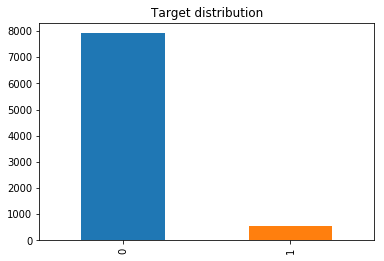

In [262]:
#Distribución muy desbalanceada
plot = df_locals['target'].value_counts().plot(kind='bar',
                                            title='Target distribution')

In [263]:
len(df_locals[df_locals['target']==1])/len(df_locals)

0.0650838648712497

## Base model
Onehot enconding   
Logistic regression   
Metrics: AUC, Precision, Recall   

In [14]:
# Load the library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [15]:
df_locals.columns

Index(['id_distrito_local', 'desc_distrito_local', 'total_local_act',
       'total_locales', 'target', 'num_loc_d', 'desc_tipo_agrup'],
      dtype='object')

In [16]:
#indicar lo que pierdo con respecto al total cuando quito coordenadas x = '0'
df_locals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 7 columns):
id_distrito_local      692 non-null int64
desc_distrito_local    692 non-null object
total_local_act        692 non-null int64
total_locales          692 non-null int64
target                 692 non-null int64
num_loc_d              692 non-null int64
desc_tipo_agrup        692 non-null object
dtypes: int64(5), object(2)
memory usage: 37.9+ KB


In [17]:
feature_names=['desc_distrito_local','total_local_act', 'total_locales', 
                        'num_loc_d','desc_tipo_agrup']
X = df_locals[feature_names]
y = df_locals['target']

Train and test

In [124]:
X_train.head()

,desc_distrito_local,total_local_act,total_locales,num_loc_d,desc_tipo_agrup
265,CENTRO,61,12178,13,SIN AGRUPACION
355,CARABANCHEL,81,8645,19,Centro Comercial
499,LATINA,40,6847,8,SIN AGRUPACION
289,ARGANZUELA,39,5522,25,SIN AGRUPACION
417,ARGANZUELA,39,5522,21,SIN AGRUPACION


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

Onehot encoding and scaling

In [19]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['total_local_act', 'total_locales','num_loc_d']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['desc_distrito_local', 'desc_tipo_agrup']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_test_p = preprocessor.transform(X_test)

Classifier

In [21]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight={1:9,0:1}))])

Fit & metrics

In [22]:
logreg.fit(X_train,y_train)

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
pred = logreg.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[119  68]
 [  8  13]]
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       187
           1       0.16      0.62      0.25        21

   micro avg       0.63      0.63      0.63       208
   macro avg       0.55      0.63      0.51       208
weighted avg       0.86      0.63      0.71       208



In [24]:
pred = logreg.predict_proba(X_test)
#pred

# Predecir lo locales que con seguridad se cerraran X_test predic_proba > 0.9

In [134]:
X_test[pred[:,1]>.9]

,desc_distrito_local,total_local_act,total_locales,num_loc_d,desc_tipo_agrup
420,ARGANZUELA,39,5522,17,Mercado Municipal
294,TETUAN,55,7351,18,Mercado Municipal


Text(0, 0.5, 'true_positives')

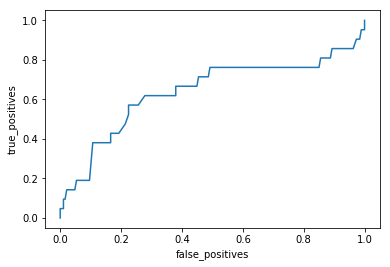

In [25]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [26]:
auc_logreg = auc(fp,tp)
auc_logreg

0.6387827858416094

In [109]:
X_train.columns

Index(['desc_distrito_local', 'total_local_act', 'total_locales', 'num_loc_d',
       'desc_tipo_agrup'],
      dtype='object')

In [125]:
X_train.iloc[0]

desc_distrito_local    CENTRO              
total_local_act                          61
total_locales                         12178
num_loc_d                                13
desc_tipo_agrup              SIN AGRUPACION
Name: 265, dtype: object

In [120]:
logreg.steps[0][1].transform(X_train)[0]

array([0.91340003, 2.25134411, 0.42485948, 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [116]:
logreg.steps[1][1].coef_

array([[ 0.38784839, -0.06886098,  0.4987171 ,  1.76182786, -0.18558672,
        -0.76090376,  0.36716139, -1.32112654, -0.10020123,  0.81543648,
        -0.69120108,  0.65607667,  0.66565176,  0.28486242,  1.97024362,
        -2.57755568,  0.5434851 ,  1.14919669, -1.61412069,  1.72661285,
        -1.39103908,  0.93457378, -1.64907069, -1.20282674,  1.01103856,
        -0.69175912, -0.69908969, -0.68025811,  0.75101022, -0.30944547]])

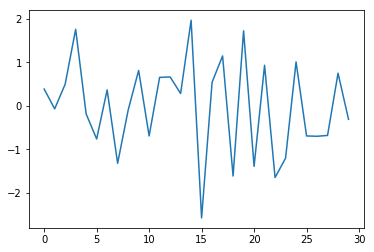

In [122]:
plt.plot(logreg.steps[1][1].coef_[0])

In [ ]:
logreg.predict

In [27]:
result = pd.DataFrame(index=['recall','auc'])
result['logreg'] = [cross_val_score(logreg,X,y,scoring='recall').mean(),auc_logreg]

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
result

,logreg
recall,0.492754
auc,0.638783


## Modeling
- KNN   
- Decission tree   
- Randon forest  
- XGboost

### Kneighbourg

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

param_grid={'classifier__n_neighbors':np.arange(4,100)}

clfk = GridSearchCV(pipe,param_grid,
                   cv = 5,
                   scoring = 'recall')

In [31]:
clfk.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_neighbors': array([ 4,  5, ..., 98, 99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [32]:
clfk.best_score_

0.10440771349862259

In [33]:
clfk.best_params_

{'classifier__n_neighbors': 5}

In [34]:
preds2 = clfk.predict(X_test)
print(confusion_matrix(y_test,preds2))
print(classification_report(y_test,preds2))

[[186   1]
 [ 20   1]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       187
           1       0.50      0.05      0.09        21

   micro avg       0.90      0.90      0.90       208
   macro avg       0.70      0.52      0.52       208
weighted avg       0.86      0.90      0.86       208



In [35]:
pred2 = clfk.predict_proba(X_test)
#pred2

Text(0, 0.5, 'true_positives')

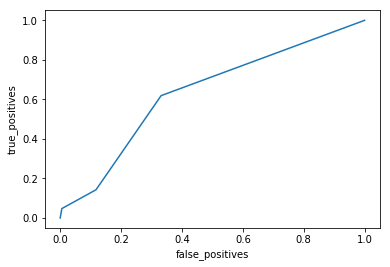

In [36]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,pred2[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [37]:
auc_clfk = auc(fp,tp)
auc_clfk

0.6334351922587217

In [38]:
result['clfknn'] = [clfk.best_score_,auc_clfk]

In [39]:
result

,logreg,clfknn
recall,0.492754,0.104408
auc,0.638783,0.633435


### Decission Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(class_weight={1:9,0:1}))])

param_grid={'classifier__max_depth':np.arange(3,10),
            'classifier__min_samples_leaf': np.arange(10,30)
                         }

clf_dt = GridSearchCV(pipe,param_grid,
                   cv = 5,
                   scoring = 'recall')

In [42]:
clf_dt.fit(X_train,y_train)

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'classifier__min_samples_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [43]:
clf_dt.best_score_

0.6885674931129476

In [44]:
clf_dt.best_params_

{'classifier__max_depth': 3, 'classifier__min_samples_leaf': 27}

In [45]:
preds4 = clf_dt.predict(X_test)
print(confusion_matrix(y_test,preds4))
print(classification_report(y_test,preds4))

[[143  44]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       187
           1       0.19      0.48      0.27        21

   micro avg       0.74      0.74      0.74       208
   macro avg       0.56      0.62      0.55       208
weighted avg       0.85      0.74      0.78       208



In [46]:
prob4 = clf_dt.predict_proba(X_test)
prob4

array([[0.5890411 , 0.4109589 ],
       [0.90425532, 0.09574468],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.1980198 , 0.8019802 ],
       [0.90425532, 0.09574468],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.90425532, 0.09574468],
       [0.26744186, 0.73255814],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.1980198 , 0.8019802 ],
       [0.90425532, 0.09574468],
       [0.25882353, 0.74117647],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.90425532, 0.09574468],
       [0.5890411 , 0.4109589 ],
       [0.4375    , 0.5625    ],
       [0.5890411 , 0.4109589 ],
       [0.5890411 , 0.4109589 ],
       [0.

Text(0, 0.5, 'true_positives')

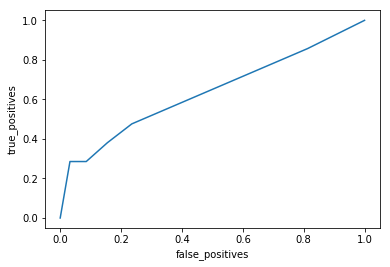

In [47]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,prob4[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [48]:
auc_clf_dt = auc(fp,tp)
auc_clf_dt

0.636236312706901

In [49]:
result['clf_dt'] = [clf_dt.best_score_,auc_clf_dt]

In [50]:
result

,logreg,clfknn,clf_dt
recall,0.492754,0.104408,0.688567
auc,0.638783,0.633435,0.636236


### Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100,class_weight={1:9,0:1}))])

param_grid={'classifier__max_depth':np.arange(3,10),
            'classifier__min_samples_leaf': np.arange(10,30)
                         }

clf_rf = GridSearchCV(pipe,param_grid,
                   cv = 5,
                   scoring = 'recall')

In [53]:
clf_rf.fit(X_train,y_train)

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...ors=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'classifier__min_samples_leaf': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [54]:
clf_rf.best_score_

0.5879476584022039

In [55]:
clf_rf.best_params_

{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 25}

In [56]:
preds3 = clf_rf.predict(X_test)
print(confusion_matrix(y_test,preds3))
print(classification_report(y_test,preds3))

[[142  45]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       187
           1       0.18      0.48      0.26        21

   micro avg       0.73      0.73      0.73       208
   macro avg       0.55      0.62      0.55       208
weighted avg       0.85      0.73      0.78       208



In [57]:
prob3 = clf_rf.predict_proba(X_test)
#prob3

Text(0, 0.5, 'true_positives')

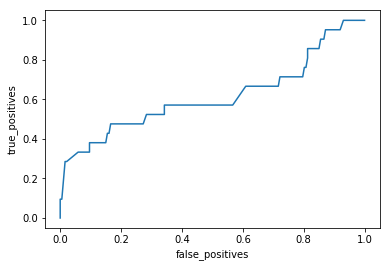

In [58]:
target_pos = 1 # Or 0 for the other class
fp,tp,thresholds = roc_curve(y_test,prob3[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [59]:
auc_clf_rf = auc(fp,tp)
auc_clf_rf

0.6152279093455565

In [60]:
auc_clf_rf

0.6152279093455565

[]

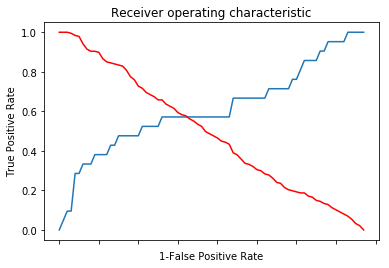

In [61]:
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tp)) # index for df
roc = pd.DataFrame({'fp' : pd.Series(fp, index=i),'tp' : pd.Series(tp, index = i), '1-fp' : pd.Series(1-fp, index = i), 'tf' : pd.Series(tp - (1-fp), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tp'])
plt.plot(roc['1-fp'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [108]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fp, tp, thresholds = roc_curve(target, predicted)
    i = np.arange(len(tp)) 
    roc = pd.DataFrame({'tf' : pd.Series(tp-(1-fp), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]

  #  return list(roc_t['thresholds'])
    return float(roc_t['thresholds'])
  

# Add prediction probability to dataframe
data = pd.DataFrame()
data['pred_proba'] = pd.Series(prob3[:,target_pos])
#data['target'] = pd.Series(y_test)

# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(y_test,data['pred_proba'])
print(threshold)


# Find prediction to the dataframe applying threshold
data['pred'] = data['pred_proba'].map(lambda x: 1 if x > threshold else 0)

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, data['pred']))
print(classification_report(y_test,data['pred']))

0.45847088218979387
[[109  78]
 [  9  12]]
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       187
           1       0.13      0.57      0.22        21

   micro avg       0.58      0.58      0.58       208
   macro avg       0.53      0.58      0.47       208
weighted avg       0.84      0.58      0.66       208



In [105]:
type(threshold)

float

In [78]:
len(tp)

3

In [96]:
fp, tp, thresholds = roc_curve(y_test,prob3[:,target_pos])
i = np.arange(len(tp)) 
roc = pd.DataFrame({'tf' : pd.Series(tp-(1-fp), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
#roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
#roc_t
roc.loc[(roc.tf-0).abs().argsort()[::]]

,tf,thresholds
32,-0.006112,0.458471
33,0.009931,0.457514
31,-0.011459,0.459288
34,0.020626,0.457322
30,-0.022154,0.459467
35,0.036669,0.449352
29,-0.043545,0.459759
36,0.047364,0.446400
28,-0.054240,0.464356
27,-0.064935,0.468211


In [71]:
preds3

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [63]:
roc.loc[(roc.tf-0).abs().argsort()[:1]]

,fp,tp,1-fp,tf,thresholds
32,0.42246,0.571429,0.57754,-0.006112,0.458471


In [64]:
result['clf_rf'] = [clf_rf.best_score_,auc_clf_rf]

In [65]:
result

,logreg,clfknn,clf_dt,clf_rf
recall,0.492754,0.104408,0.688567,0.587948
auc,0.638783,0.633435,0.636236,0.615228


In [66]:
X_train_p = preprocessor.fit_transform(X_train)
clf_rf2 = RandomForestClassifier(n_estimators=100,max_depth = 3,
                                                            min_samples_leaf=20,class_weight={1:9,0:1})

clf_rf2.fit(X_train_p,y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 9, 0: 1},
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [67]:
pred5 = clf_rf2.predict(X_test_p)
print(confusion_matrix(y_test,pred5))
print(classification_report(y_test,pred5))

NameError: name 'X_test_p' is not defined

In [ ]:
prob5 = clf_rf2.predict_proba(X_test_p)
prob5

In [ ]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,prob5[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [ ]:
auc_clf_rf2 = auc(fp,tp)
auc_clf_rf2

In [ ]:
X_p = preprocessor.transform(X)
result['clf_rf2'] = [cross_val_score(clf_rf2,X_p,y,scoring='recall').mean(),auc_clf_rf2]

In [ ]:
result

In [ ]:
X_p

In [ ]:
#no funciona cuando escalo los valores de X. Y una vez escalados, X ya se ha convertido en un array. Ver si se puede mantener Dataframe
#importantes = pd.DataFrame(clf_rf2.feature_importances_,index=X.columns,columns=['importance']).sort_values('importance', ascending=False)
importantes = pd.DataFrame(clf_rf2.feature_importances_,columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
importantes

In [ ]:
def plot_categorical(df, var_name, target_name, width=7, height=5, color='#13A844'):
 

    # crea el ratio de target por categoria:

    proporcion_target =  df.loc[:, [target_name, var_name]].groupby([var_name]).mean()

 

    # realiza un conteo por categoria

    distribucion_categoria = df.loc[:, [target_name, var_name]].groupby([var_name]).count()

 

    # genera el gráfico

    fig = plt.figure(figsize=(width, height))

    ax = distribucion_categoria[target_name].plot(kind='bar', color=color)

    ax.set_ylabel('Numero de samples', color=color)

    ax2 = ax.twinx()

    ax2.grid(False)

    ax2.plot(proporcion_target[target_name].values, color='r', linestyle='-', alpha=0.9, marker = '.', markeredgewidth = 2, linewidth=1.0)

    ax2.set_ylabel('ratio target', color='r')

    plt.title('Descripción de variable ' + var_name)

    plt.show()

In [ ]:
plot_categorical(df_locals_p, 'desc_distrito_local_VILLAVERDE          ', 'target', width=7, height=5, color='#13A844')

In [ ]:
X.columns

### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(n_estimators=100,
                                       colsample_bytree=0.3))])

param_grid={'classifier__max_depth':np.arange(3,10),
            'classifier__learning_rate': np.arange(1,10)/10}

clf_xgb = GridSearchCV(pipe,param_grid,
                   cv = 5,
                   scoring = 'recall')

In [ ]:
clf_xgb.fit(X_train,y_train)

In [ ]:
clf_xgb.best_score_

In [ ]:
clf_xgb.best_params_

In [ ]:
preds4 = clf_xgb.predict(X_test)
print(confusion_matrix(y_test,preds4))
print(classification_report(y_test,preds4))

In [ ]:
prob4 = clf_xgb.predict_proba(X_test)
prob4

In [ ]:
target_pos = 1 # Or 0 for the other class
fp,tp,_ = roc_curve(y_test,prob4[:,target_pos])
plt.plot(fp,tp)
plt.xlabel("false_positives")
plt.ylabel("true_positives")

In [ ]:
auc_clf_xgb = auc(fp,tp)
auc_clf_xgb

In [ ]:
result['clf_xgb'] = [clf_xgb.best_score_,auc_clf_xgb]

In [ ]:
result

## Compare Metrics

## Interpretabilitiy

### Permutations importance

with ELI5
To understand the features that are important for a model
If I shuffle the values of a feature and the result of the model doesn't change, it means that the feature is not relevant for the model
It is calculated after the model has been fit

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clfk.best_estimator_,random_state=1).fit(X_test_p,y_test)
eli5.show_weights(perm, feature_names= X_test_p.columns.tolist())

In [ ]:
clfk.best_estimator_

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
#X_test_p = preprocessor.fit_transform(X_test).toarray()
X_test_p = preprocessor.transform(X_test)
perms = PermutationImportance(clfk.best_estimator_,random_state=1).fit(X_test_p.toarray(),y_test)
#eli5.show_weights(perms)

In [128]:
pd.DataFrame(X_train.values)

,0,1,2,3,4
0,CENTRO,61,12178,13,SIN AGRUPACION
1,CARABANCHEL,81,8645,19,Centro Comercial
2,LATINA,40,6847,8,SIN AGRUPACION
3,ARGANZUELA,39,5522,25,SIN AGRUPACION
4,ARGANZUELA,39,5522,21,SIN AGRUPACION
5,PUENTE DE VALLECAS,56,6800,8,Centro Comercial
6,TETUAN,55,7351,20,SIN AGRUPACION
7,CARABANCHEL,81,8645,19,Centro Comercial
8,SAN BLAS-CANILLEJAS,26,4839,6,Centro Comercial
9,MONCLOA-ARAVACA,24,4381,11,Centro Comercial
